In [104]:
using MIRTjim
using Plots
using FFTW
using Random
using LinearAlgebra
using MAT

include("utils.jl");

LoadError: LoadError: cannot define function even_RL; it already has a value
in expression starting at /home/djfrey/code/projects/pisco.jl/utils.jl:4

In [105]:
# read in data from mat file
kdata = matread("./data/2D_T1_data.mat")["kData"];

# get sizes
nd = ndims(kdata) - 1; # number of image dimensions
N = size(kdata)[1:nd]; # image size
Q = size(kdata, nd + 1); # number of channels

In [106]:
# set PISCO parameters
τ = Int(3); # neighborhood size (radius)
N_cal = 32; # size of calibration region
σ_thresh = 0.002; # threshold for singular values
d_sk = 50; # sketch dimension for SVD of ChC (overestimation of the rank)

# set PISCO techniques
kernel_shape = 1; # (0 for rect, 1 for circle)
fft_conv_mtx = 1; # option to approximate ChC with FFTs

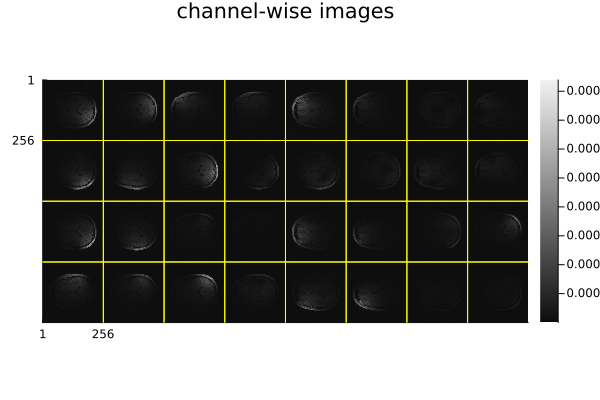

In [107]:
# get aliased image
idata = fftshift(ifft(ifftshift(kdata,1:nd),1:nd),1:nd);
jim(idata, title="channel-wise images")

In [108]:
# extract calibration data from kcal
cal_subs = [ceil.(Int,N[d]/2) + even_RL(N[d]/2) .+
    (-floor(Int,N_cal/2):floor(Int,N_cal/2)-even_RL(N_cal/2))
    for d in 1:nd]; # subscript indices for calibration region (vector of vectors for each dim)
kcal = kdata[cal_subs..., :];

# create kernel neighborhood
Λ_ind = grid([-τ:τ for d in 1:nd]...); # linear indices for kernel neighborhood
if kernel_shape == 1
    cmask = vec(sum(Λ_ind.^2, dims=2)) .<= τ^2;
    Λ_ind = Λ_ind[cmask, :] # mask out edges if using ellipsoidal kernel
end
Λ_len = size(Λ_ind,1); # final kernel (patch) size

In [ ]:
# form the convolution gram matrix ChC
if fft_conv_mtx == 0 # naive approach

    # calculate convolution matrix C
    C = zeros(ComplexF64, (N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len, Q)
    k = grid(ntuple(d -> τ+1+even_RL(N_cal):N_cal-τ, nd)...); # grid of shift points
    for i in 1:size(k,1)
        idcs = ntuple(d -> k[i, d] .+ Λ_idcs[:, d], nd); # shifted indicies
        for q in 1:Q
            C[i,:,q] .= getindex.(Ref(kcal), idcs..., q);
        end
    end
    C = reshape(C, ((N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len*Q)); # reshape

    # calculate ChC via matrix product
    ChC = C'*C;

else # direct FFT-based approach

    # precompute ft of zero-padded s_q for q = 1,...Q
    N_pad = 2^(ceil(log2(N_cal + 2 * τ)))
    s = zeros(ComplexF64, Int.(N_pad * ones(nd))..., Q)
    cal_subs_pad = [ceil.(Int, N_pad / 2) + even_RL(N_pad / 2) .+
                    (-floor(Int, N_cal / 2):floor(Int, N_cal / 2)-even_RL(N_cal / 2))
                    for d in 1:nd] # subscript indices for calibration region (padded)
    s[cal_subs_pad..., :] .= kcal # zero-padded s
    ρ = fftshift(fft(s, 1:nd), 1:nd) # ft of zero-padded s

    # columns of each C_p^H C_q block
    ChC_blocks = zeros(ComplexF64, Λ_len, Λ_len, Q, Q);
    pad_idcs = grid(ntuple(_ -> -floor(Int, N_pad / 2):floor(Int, N_pad / 2)-even_RL(N_pad / 2), nd) ...); # linear indices for padded calibration region
    φ = exp.(-1im * 2 * pi * (Λ_idcs / N_pad) * pad_idcs'); # phase kernel for applying shifts in fourier domain
    for p in 1:Q
        for q in 1:Q
            # compute ft(s_p[n] ⊗ conj(s_q[-n])) = ρ_p* * ρ_q
            ρρ_pq = conj(ρ[ntuple(_ -> Colon(), nd)..., p]) .* ρ[ntuple(_ -> Colon(), nd)..., q];
            for i in 1:Λ_len # loop through all shift indices
                # compute ft(δ[n - n_i] ⊗ s_p[n] ⊗ conj(s_q[-n])) = φ_i * conj(ρ_p) * ρ_q
                φρρ_pqi = reshape(φ[i,:], size(ρρ_pq)) .* ρρ_pq;
                δss_pqi = fftshift(ifft(ifftshift(φρρ_pqi, 1:nd), 1:nd), 1:nd);

                # extract patch and write to ChC block
                idcs = ntuple(d -> round(Int, N_pad / 2) + even_RL(N_pad / 2) .+ Λ_idcs[:, d], nd);
                ChC_blocks[:, i, p, q] .= getindex.(Ref(δss_pqi), idcs...);
            end
        end
    end

    # reshape blocks
    ChC = reshape(permutedims(ChC_blocks, (1, 3, 2, 4)), Λ_len * Q, Λ_len * Q);

end

928×928 Matrix{ComplexF64}:
   9.10766e-8+6.61744e-24im  …   2.21229e-10-2.95948e-10im
  -3.47819e-8+1.41909e-8im      -3.24873e-10-8.8273e-11im
   3.20397e-8+5.29194e-8im       5.41794e-10+1.69404e-10im
   6.37909e-8-4.01498e-8im       1.85327e-10-5.95625e-10im
  -3.92969e-8-4.9192e-8im       -2.55182e-10+1.2565e-10im
  -2.53666e-8+3.75261e-8im   …    3.1632e-10+1.90727e-10im
  -8.49237e-9+1.74939e-8im      -4.13832e-10+1.27737e-9im
   3.21554e-8+1.25238e-8im        1.45645e-9-1.23734e-10im
   1.40268e-8-4.17439e-8im      -3.23337e-10-1.02541e-9im
  -4.09801e-8-6.10325e-9im      -3.53898e-10+4.67943e-10im
             ⋮               ⋱  
 -3.23337e-10+1.02541e-9im      -1.09037e-10+3.42366e-10im
   1.45645e-9+1.23734e-10im  …   2.02746e-10+1.38692e-10im
 -4.13832e-10-1.27737e-9im      -2.65877e-11+1.87584e-11im
   3.1632e-10-1.90727e-10im     -6.69282e-11-4.93163e-10im
 -2.55182e-10-1.2565e-10im      -1.17277e-10+6.3209e-10im
  1.85327e-10+5.95625e-10im       1.35761e-9+5.5512e-10im
 

In [116]:
# take the SVD of C to find its null space
(~,σ,V) = svd(ChC);
r = count(σ/σ[1] .> σ_thresh);
V0 = V[:, 1:r];
#V0 = V[:, r+1:end]; # get the null space basis of C
P = size(V0, 2); # number of null space basis vectors

In [117]:
# ft the filters to the image domain
f_p = zeros(ComplexF64, P, Q, N...);
for i in 1:Λ_len
    f_p[:, :, [Int(N[d]/2) + Λ_idcs[i,d] for d in 1:nd]...] .= reshape(conj.(V0'), P, Λ_len, Q)[:,i,:];
end
h_p = fftshift(ifft(ifftshift(f_p, 3:nd+2), 3:nd+2), 3:nd+2);

In [118]:
# form H matrix
H = reshape(h_p,P,Q,prod(N));

# estimate sensitivity maps
smaps_est = zeros(ComplexF64, Q, prod(N));
ev_est = zeros(ComplexF64, Q, prod(N));
for x in 1:prod(N) # loop through vo/pixels
    # estimate sensitivity at x as last null space vector of H(x)
    (~,σ,V) = svd(H[:,:,x]'*H[:,:,x]);
    smaps_est[:,x] = V[:,1];
    ev_est[:,x] = σ;
    #smaps_est[:,x] = V[:,end];
end
smaps_est = permutedims(reshape(smaps_est, Q, N...),((2:nd+1)...,1));

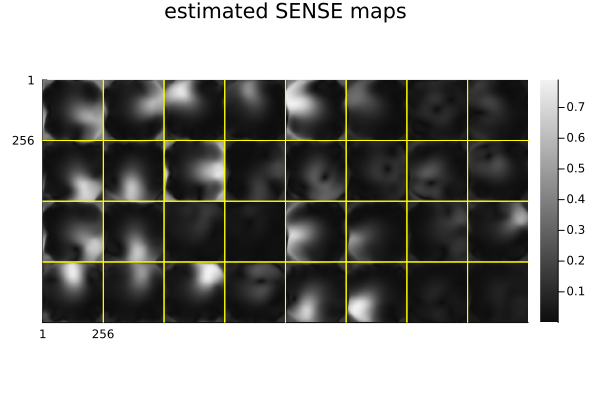

In [119]:
# show the sensitivity maps
jim(smaps_est, title="estimated SENSE maps")

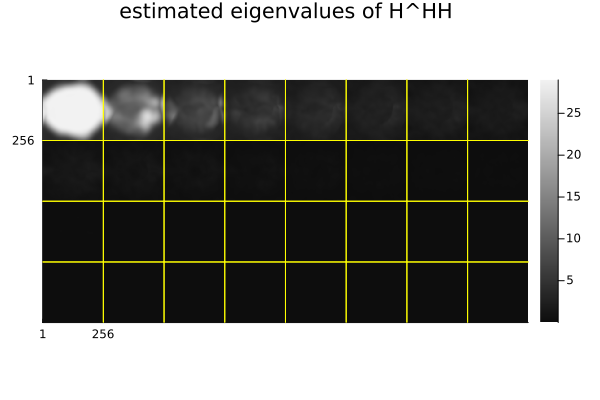

In [123]:
# show the eigenvalues of H'H
jim(prod(N)^nd * reshape(ev_est', N..., Q), title="estimated eigenvalues of H^HH")

To do:
- calculate NPR based on changes:
    - estimate ChC with FFT and see change in NPR